In [97]:
import numpy as np
from scipy.signal import firwin, filtfilt
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

In [117]:
def filter_eeg_data(single_trial_data, sfreq, freq, bandwidth=3):
    nyq = sfreq / 2
    freqmin = freq - bandwidth / 2
    freqmax = freq + bandwidth / 2
    data_length = len(single_trial_data)
    max_filter_order = data_length // 3
    filter_order = min(round(3 * (sfreq / freqmin)), max_filter_order)
    b = firwin(filter_order, [freqmin, freqmax], pass_zero=False, window='hamming', fs=sfreq)
    padlen = min(len(b) * 3, data_length - 1)
    filtered_data = filtfilt(b, 1, single_trial_data, padlen=padlen)
    return filtered_data

def compute_fft_ifft(data, fs):
    fft_data = np.fft.fft(data, axis=0)
    # Create a complex copy of "f"
    complex_fft_data = 1j * fft_data  # Multiplying by the complex operator "i"
    # Identify the positive and negative frequencies
    n = fft_data.shape[0]
    positive_frequencies = np.arange(0, n // 2 + 1)
    negative_frequencies = np.arange(n // 2 + 1, n)
    # Separate "Complexf" and "f" for positive and negative frequencies
    positive_complex = complex_fft_data[positive_frequencies]
    negative_complex = complex_fft_data[negative_frequencies]
    # Rotate Complexf by -90 degrees for positive frequencies
    # and by +90 degrees for negative frequencies
    positive_complex *= np.exp(-1j * np.pi / 2)
    negative_complex *= np.exp(1j * np.pi / 2)
    # Add the rotated positive Complexf to the positive frequency coefficients ("f")
    fft_data[positive_frequencies] += positive_complex
    # Do the same for the negative frequencies
    fft_data[negative_frequencies] += negative_complex
    # Take the inverse Fourier transform (ifft)
    analytic_signal = np.fft.ifft(fft_data, axis=0)
    return analytic_signal

def normalized_morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)  # Complex sine wave
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)  # Gaussian envelope
    wavelet = sine_wave * amplitude_envelope
    wavelet /= np.sqrt(np.sum(np.abs(wavelet)**2))  # Normalize wavelet to have unit energy
    return wavelet

def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)  # Complex sine wave
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)  # Gaussian envelope
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def wavelet_convolution(single_trial_data, wavelet):
    n_signal = len(single_trial_data)
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1
    data_fft = np.fft.fft(single_trial_data, n_convolution)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)
    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft)
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[start:end]


In [118]:
mat_file_path = 'sampleEEGdata.mat'
mat_data = scipy.io.loadmat(mat_file_path)
eeg_data = mat_data['EEG']

# Access the data and channel location fields
eeg_data_field = eeg_data['data'][0, 0]
chanlocs_field = eeg_data['chanlocs'][0, 0]
sampling_rate = eeg_data['srate'][0, 0][0, 0]
channel_labels = [chanlocs_field['labels'][0][i][0] for i in range(chanlocs_field['labels'].shape[1])]
cz_index = channel_labels.index('Cz')
cz_data = eeg_data_field[cz_index, :, :]  # Data is in the format [channels, times, trials]

frequencies = [5, 25]  
num_trials = cz_data.shape[1]  
sampling_rate = 256
num_cycles = 4

filtered_data = {}
for freq in frequencies:
    filtered_data[freq] = np.zeros_like(cz_data) 
    for trial in range(num_trials):
        filtered_data[freq][:, trial] = filter_eeg_data(cz_data[:, trial], sampling_rate, freq)

fft_results = {}
power = {}
real_component = {}
phase = {}
# FFT and analytic signal computation
fft_results = {freq: compute_fft_ifft(filtered_data[freq], sampling_rate) for freq in frequencies}

# Extract power and real components
analytic_signals_fft = {
    freq: {
        'power': np.mean(np.abs(signal)**2, axis=1),
        'real': np.mean(np.real(signal), axis=1)
    } for freq, signal in fft_results.items()
}

avg_power_wavelet = {freq: np.zeros(cz_data.shape[0]) for freq in frequencies}
avg_real_wavelet = {freq: np.zeros(cz_data.shape[0]) for freq in frequencies}
for freq in frequencies:
    for trial in range(num_trials):
        # Filter the data
        filtered_data = filter_eeg_data(cz_data[:, trial], sampling_rate, freq)
        # Wavelet Convolution
        wavelet = morlet_wavelet(freq, num_cycles, sampling_rate)
        convolved_data = wavelet_convolution(filtered_data, wavelet)
        avg_power_wavelet[freq] += np.abs(convolved_data)
        avg_real_wavelet[freq] += np.real(convolved_data)    
    avg_power_wavelet[freq] /= num_trials
    avg_real_wavelet[freq] /= num_trials

# Normalized Morlet Wavelet Convolution
avg_power_wavelet_n = {freq: np.zeros(cz_data.shape[0]) for freq in frequencies}
avg_real_wavelet_n = {freq: np.zeros(cz_data.shape[0]) for freq in frequencies}
for freq in frequencies:
    wavelet_n = normalized_morlet_wavelet(freq, num_cycles, sampling_rate)  # Use the normalized wavelet
    for trial in range(num_trials):
        filtered_data_n = filter_eeg_data(cz_data[:, trial], sampling_rate, freq)
        convolved_data_n = wavelet_convolution(filtered_data, wavelet)
        avg_power_wavelet_n[freq] += np.abs(convolved_data)**2
        avg_real_wavelet_n[freq] += np.real(convolved_data)   
    avg_power_wavelet_n[freq] /= num_trials
    avg_real_wavelet_n[freq] /= num_trials

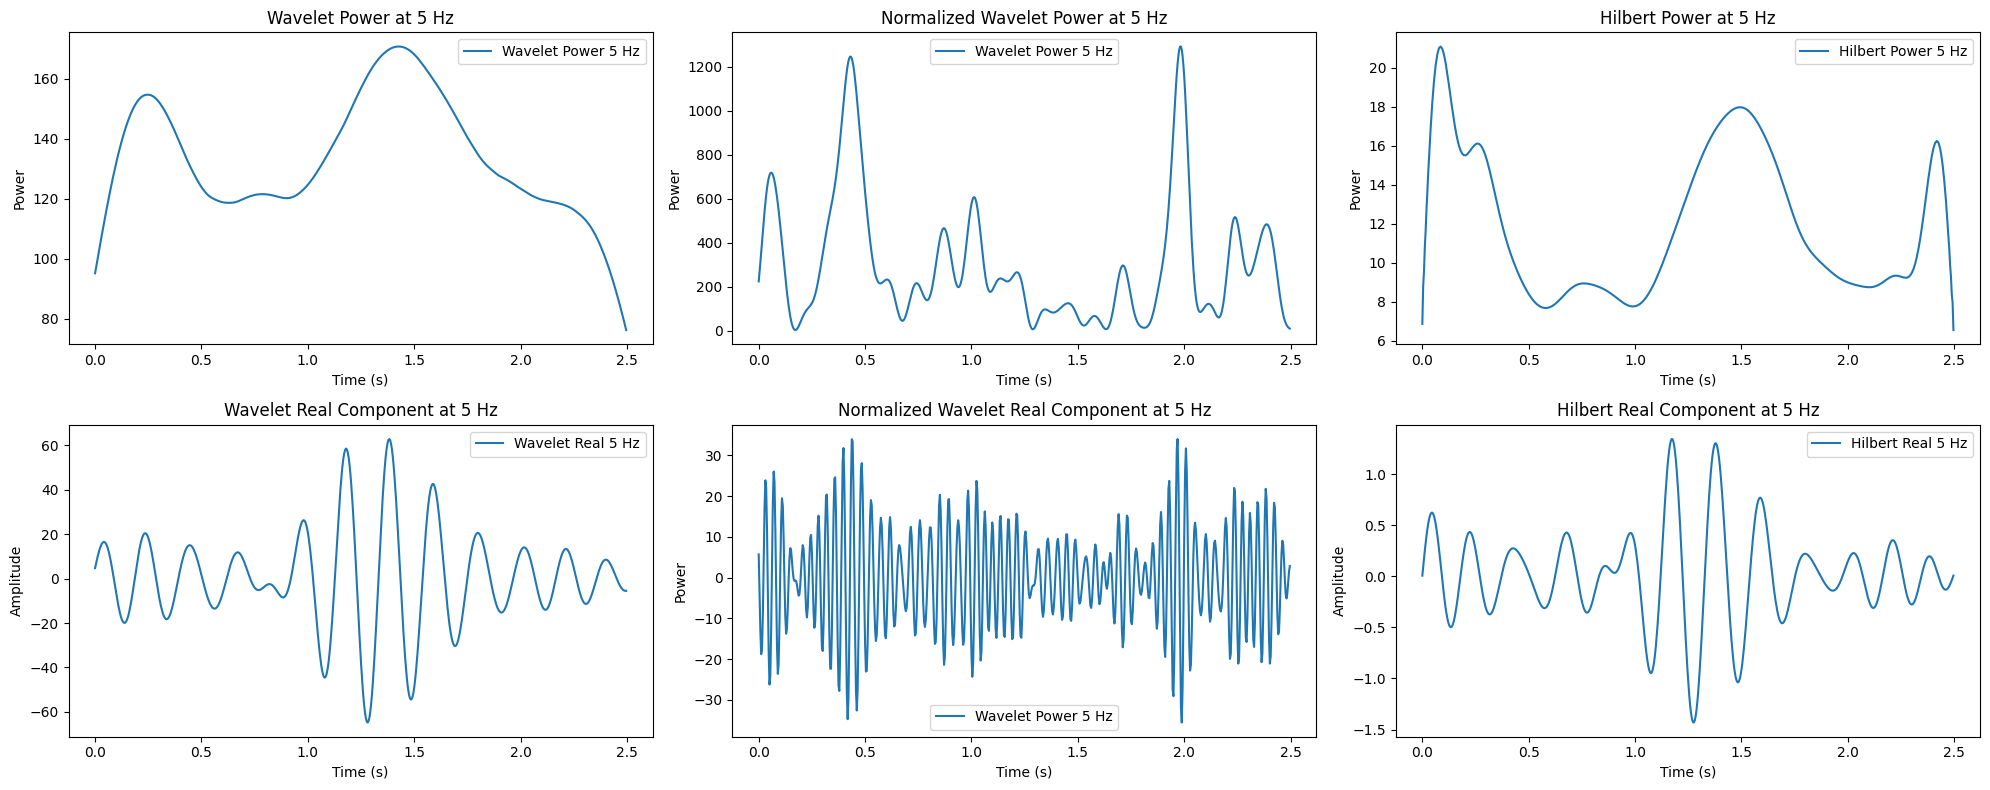

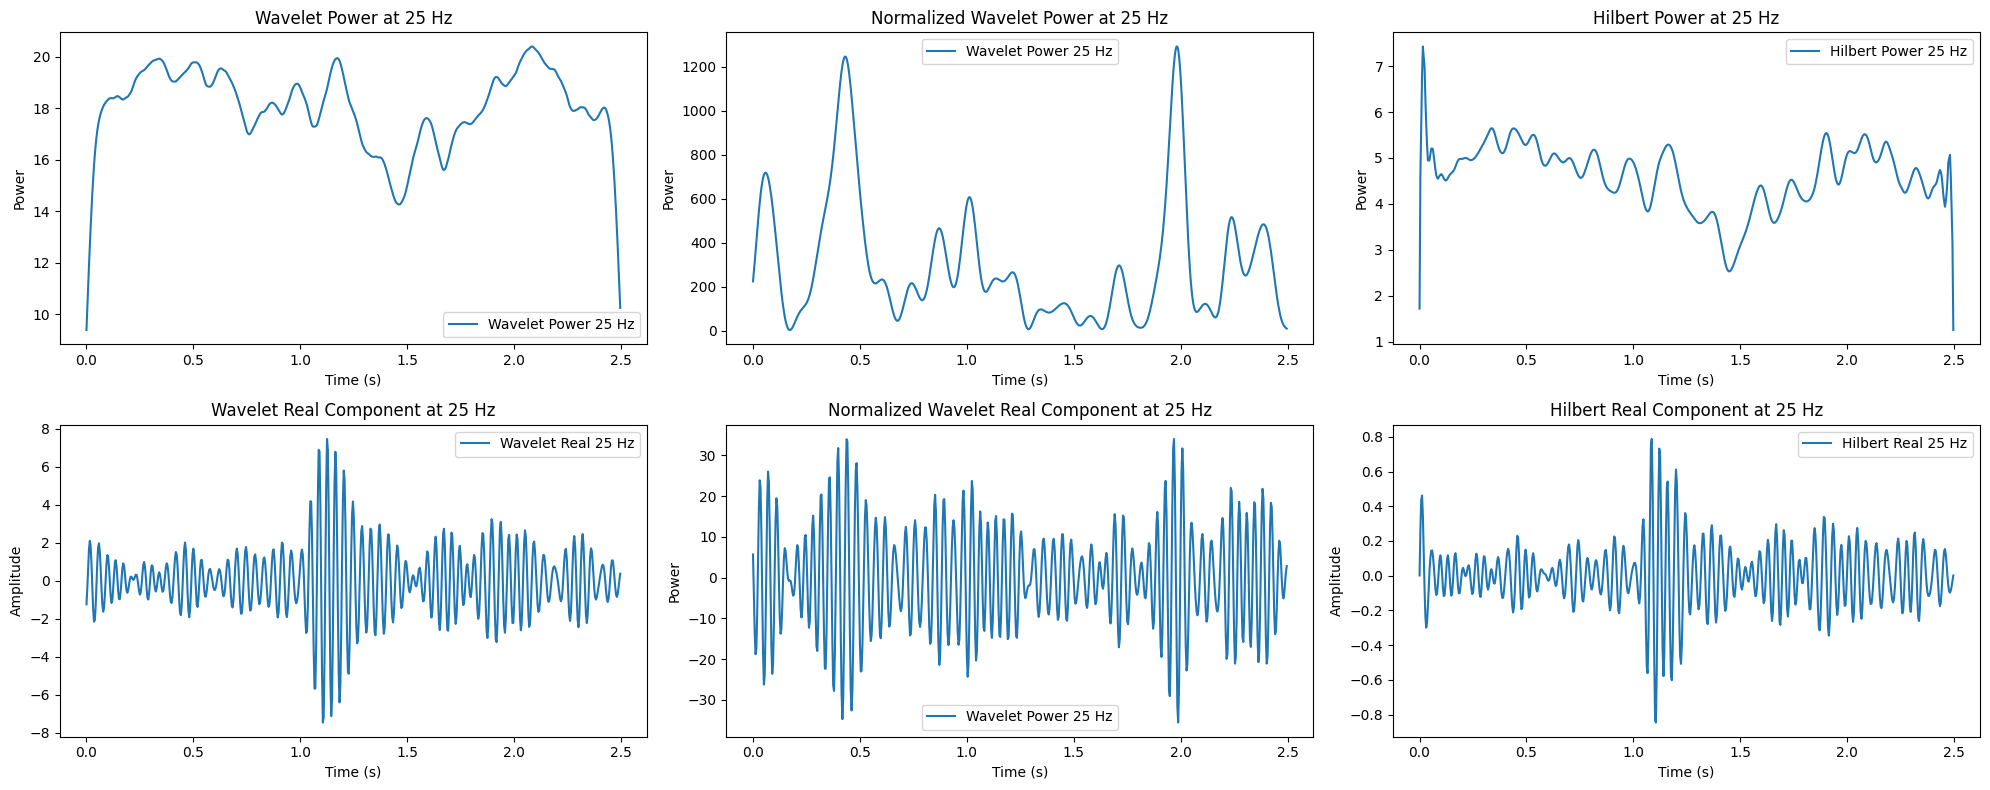

In [119]:
times = np.arange(cz_data.shape[0]) / sampling_rate

for freq in frequencies:
    plt.figure(figsize=(20, 8))  # Increased width to accommodate 2x2 subplots
    
    # Wavelet Power
    plt.subplot(2, 3, 1)  # This is the first plot in a 2x2 subplot layout
    plt.plot(times, avg_power_wavelet[freq], label=f'Wavelet Power {freq} Hz')
    plt.title(f'Wavelet Power at {freq} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.legend()
    
    # Normalized Wavelet Power
    plt.subplot(2, 3, 2)  
    plt.plot(times, avg_power_wavelet_n[freq], label=f'Wavelet Power {freq} Hz')
    plt.title(f'Normalized Wavelet Power at {freq} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.legend()
    
    # Hilbert Power
    plt.subplot(2, 3, 3)  # This is the second plot, on the right of the first plot
    plt.plot(times, analytic_signals_fft[freq]['power'], label=f'Hilbert Power {freq} Hz')
    plt.title(f'Hilbert Power at {freq} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.legend()
    
    # Wavelet Real Component
    plt.subplot(2, 3, 4)  # This is the third plot, below the first plot
    plt.plot(times, avg_real_wavelet[freq], label=f'Wavelet Real {freq} Hz')
    plt.title(f'Wavelet Real Component at {freq} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Normalized Wavelet Real Component
    plt.subplot(2, 3, 5)  
    plt.plot(times, avg_real_wavelet_n[freq], label=f'Wavelet Power {freq} Hz')
    plt.title(f'Normalized Wavelet Real Component at {freq} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.legend()
    
    # Hilbert Real Component
    plt.subplot(2, 3, 6)  # This is the fourth plot, below the second plot
    plt.plot(times, analytic_signals_fft[freq]['real'], label=f'Hilbert Real {freq} Hz')
    plt.title(f'Hilbert Real Component at {freq} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()


Similarities:

Both methods allow for the extraction of the signal's amplitude (or power) and phase information at specific frequencies over time, as evidenced by the plotted real components and power for both 5 Hz and 25 Hz frequencies.
The plots demonstrate that both methods can capture changes in the signal's power and phase over time, which is crucial for time-frequency analysis in EEG data.
Each method seems to resolve the frequency components at 5 Hz and 25 Hz, showing the expected behavior of the signal at these frequencies.


Differences:

The wavelet transform typically provides better frequency resolution due to the variable window size that adapts based on the frequency. This might be evident in the power and real component plots at 5 Hz and 25 Hz, where the wavelet plots may show more detailed variations compared to the Hilbert transform.
The Hilbert transform often results in a smoother representation of the signal, which might make it less capable of capturing rapid transient changes compared to the wavelet transform. This could be seen in the smoother curves in the Hilbert transform plots.
The amplitude scales differ between the two methods, which could be due to different normalization or scaling factors applied during the transforms. The wavelet power appears to be on a larger scale than the Hilbert power, suggesting differences in how the two methods estimate signal energy.


Here are some potential causes for the differences observed in the magnitude and patterns between the Hilbert and Wavelet transform outputs:


Normalization:

The normalized Morlet wavelet is designed to have unit energy, which means that the magnitude of the wavelet convolution output will be influenced by the signal itself rather than the wavelet. This normalization ensures that the convolution reflects the actual energy present in the signal at the frequency of interest.
In contrast, the non-normalized Morlet wavelet does not have this property, and its convolution with the signal can produce outputs with magnitudes that reflect the wavelet's energy. This can lead to differences in the magnitudes between normalized and non-normalized wavelet convolutions.


Windowing Effect:

The Morlet wavelet is essentially a windowed sinusoid, and its width is governed by the number of cycles specified. A Morlet wavelet with a smaller number of cycles will have a shorter time window, resulting in better temporal resolution but worse frequency resolution. Conversely, more cycles will give better frequency resolution but worse temporal resolution.
Bandwidth and Frequency Resolution:

The bandwidth of the filter used in the Hilbert transform can affect the range of frequencies analyzed around the central frequency. A narrow bandwidth may not capture all the energy present in a broad signal spectrum, while a wide bandwidth might include more noise or other signal components.
The Wavelet transform inherently has better frequency resolution due to the wavelet's adaptability to different frequencies.


Analysis Method:

The Hilbert transform uses the analytic signal to compute the amplitude envelope and instantaneous phase of the signal. It assumes a narrowband signal where the instantaneous frequency does not vary much.
The Wavelet transform provides a more localized time-frequency representation of the signal. This can lead to more pronounced transient features in the wavelet power and real component plots, as it can adapt to changes in frequency content over time.

Averaging Process:

For the wavelet transform,I am summing the power or amplitude before averaging, which could amplify any variations or noise in the signal. For the Hilbert transform, I am  directly averaging the squared absolute values or the real parts, which can smooth out these variations.

Phase Relationship in FFT:

In my Hilbert transform computation, I am manipulating the phase of the FFT components to create the analytic signal, which can lead to differences in how the signal's amplitude and phase are represented compared to the Wavelet transform.


In conclusion, the choice of whether to normalize a wavelet or not and the method used to compute the analytic signal can have significant effects on the resulting time-frequency representation. 




